<a href="https://colab.research.google.com/github/MatthewG45/Covid-19_Spread_Factors_Simulation/blob/main/Covid_19_Simulation_modellingFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

def run_simulation(population_size, initial_infected, base_infection_probability, demographic_growth_rate, days, temperature_effect, mortality_rate, avg_length_sick, temperature, interactions_per_day, antibody_effectiveness):
  print("Start Simulation")

  recovered_to_infected= 0

  # calculates a gaussian curve of probability for mortality rate per day, with a higher death chance in the middle of the sickness vs on the ends.
  death_rate_per_day = [abs(ele) for ele in (sorted([random.gauss(mortality_rate, 1/3) for _ in range(int(avg_length_sick))]))]
  for i in range(len(death_rate_per_day)):
    death_rate_per_day[i] = death_rate_per_day[i]/1000

  # chaning infection probability by temperature input
  def adjust_infection_probability(base_prob, temp):
    if temp < 20: # essentially, increases infection probability the colder it is, and it does not change above 20C (stays as base)
      return base_prob + (20 - temp) * temperature_effect
    return base_prob
  infection_probability = adjust_infection_probability(base_infection_probability, temperature)

  # Initialize populations to zero for each simulation
  population = np.zeros(population_size)
  population_infected_days = np.zeros(population_size)

  # define random person(s) in the population array to be infected
  population[np.random.choice(population_size, initial_infected, replace=False)] = 1
  infected_counts = [initial_infected]
  deathcounts = []
  recoveredcounts = []
  healthycounts = []

  # Now, iterate over the number of simulation days
  for day in range(days):
    for person in range(population_size): # now, iterate over every single person in the population
      if person < len(population) and population[person] == 1: # only consider those that are infected

        # Here we determine how long they have been infected, if they die from sickness, and if they recover
        if population_infected_days[person] > 0: # consider those with at least 1 day infected (always true)
          if population_infected_days[person] < avg_length_sick: # only consider if they are within avg_length_sick days of infection
            if np.random.random() < death_rate_per_day[int(population_infected_days[person])]: # here, we generate a random number and compare it against the death rate for their day length of sickness
              population[person] = 2
            population_infected_days[person] += 1 # if they do not die, increment their number of days infected
          else:
            population[person] = 3 # if they are not within avg_length_sick days of infection and did not die, they become immune and recover

        # Here, we determine who this sick person infects
        if person < len(population) and population[person] == 1: # check if they are sick again since they may have died or recovered
          for _ in range(interactions_per_day): # now, because the person is sick, iterate over each of their interactions with other people
            other_person = np.random.randint(0, population_size) # get a random person
            if population[other_person] == 0: # check if that random person is healthy
              if np.random.random() < infection_probability: # generate a random number and compare it against the infection rate to determine if they become infected
                population[other_person] = 1
                population_infected_days[other_person] += 1 # increment their days infected

            # recovered people can still be infected, but at a low chance depending on how shortly they have been recovered
            if population[other_person] == 3: # check if the person is a recovered victim
              if population_infected_days[other_person] < antibody_effectiveness[0][0]: # check if they have been infected under a certain number of days
                population_infected_days[other_person] += 1 # in this case they are immune, so only increment days infected (always assume days recovered is (days infected - 10))
              elif population_infected_days[other_person] < antibody_effectiveness[1][0]:
                if np.random.random() < infection_probability*antibody_effectiveness[1][1]: # since they are no longer immune infect them at a factored chance by the antibody effectiveness
                  population[other_person] = 1
                  population_infected_days[other_person] = 0
                  population_infected_days[other_person] += 1
                  recovered_to_infected += 1
                population_infected_days[other_person] += 1

              elif population_infected_days[other_person] < antibody_effectiveness[2][0]:
                if np.random.random() < infection_probability*antibody_effectiveness[2][1]:
                  population[other_person] = 1
                  population_infected_days[other_person] = 0
                  population_infected_days[other_person] += 1
                  recovered_to_infected += 1
                population_infected_days[other_person] += 1

              elif population_infected_days[other_person] < antibody_effectiveness[3][0]:
                if np.random.random() < infection_probability*antibody_effectiveness[3][1]:
                  population[other_person] = 1
                  population_infected_days[other_person] = 0
                  population_infected_days[other_person] += 1
                  recovered_to_infected += 1
                population_infected_days[other_person] += 1

              elif population_infected_days[other_person] > antibody_effectiveness[4][0]: ##last elif, days recovered is now > rather than <, person no longer has antibodies
                if np.random.random() < infection_probability*antibody_effectiveness[4][1]:
                  population[other_person] = 1
                  population_infected_days[other_person] = 0
                  population_infected_days[other_person] += 1
                  recovered_to_infected += 1
                population_infected_days[other_person] += 1


    # now, we add the demographic growth to the current population
    new_individuals = int(population_size * demographic_growth_rate) # calculate the amount of new individuals
    population = np.append(population, np.zeros(new_individuals)) # add the new individuals to the population as healthy

    population_infected_days = np.append(population_infected_days, np.zeros(new_individuals)) # add the new individuals to the population as healthy

    population_size += new_individuals # increment the population_size used for determining

    healthy = 0
    deathcount = 0
    recovered = 0
    infected_count=0
    for person in range(len(population)):
      if population[person] == 2:
        deathcount += 1
      elif population[person] == 3:
        recovered += 1
      elif population[person] == 1:
        infected_count+=1
      elif population[person] == 0:
        healthy+=1
    infected_counts.append(infected_count)
    deathcounts.append(deathcount)
    recoveredcounts.append(recovered)
    healthycounts.append(healthy)


    # if statement for printing day epoch
    # prints zero'th day as 1, and every 5th day after
    if day == 0:
      print(f"Day {day}: {infected_counts[day]} people are infected, {deathcount} people are dead, {recovered} people have recovered, {healthy} people are still healthy, {recovered_to_infected} people have been re-infected, Population: {population_size}")
    elif day%10 == 0:
      print(f"Day {day}: {infected_counts[day]} people are infected, {deathcount} people are dead, {recovered} people have recovered, {healthy} people are still healthy, {recovered_to_infected} people have been re-infected, Population: {population_size}")

    # if statement for ending early if healthy population is less than 1% of population
    if population_size*0.9999 < infected_counts[day]:
      if day+1 == days:
        print(f"Day {day}: {infected_counts[day]} people are infected, {deathcount} people are dead, {recovered} people have recovered, {healthy} people are still healthy, {recovered_to_infected} people have been re-infected, Population: {population_size}")
      elif day%10 != 0:
        print(f"Day {day}: {infected_counts[day]} people are infected, {deathcount} people are dead, {recovered} people have recovered, {healthy} people are still healthy, {recovered_to_infected} people have been re-infected, Population: {population_size}")

      return infected_counts, deathcount, recovered, healthy, deathcounts, recoveredcounts, healthycounts

  return infected_counts, deathcount, recovered, healthy, deathcounts, recoveredcounts, healthycounts

In [2]:
# Base variables
population_size = 100000 # in num of persons
initial_infected = 1 # in num of persons
base_infection_probability = 0.03 # in %
demographic_growth_rate = 0.029/365 # in %, canadas annual growth rate divided by the days in a year
days = 100 # simulation time
temperature_effect = 0.01 # temp factor
mortality_rate = 61.3/100000*2 # deaths per 100000
avg_length_sick = 10 # in days
temperature = 15 # in C
interactions_per_day = 15
antibody_effectiveness = [[15, 0], # [[days sick - avg_length_sick, infection rate factor]] #factor of 0 since they are immune
                          [25, 0.2],
                          [30, 0.5],
                          [35, 0.9],
                          [35, 1]] # last one matchs no. days since its a greater than, also has 1 factor since antibodies are no longer effective

Base Factor values

Start Simulation
Day 0: 1 people are infected, 0 people are dead, 0 people have recovered, 100006 people are still healthy, 0 people have been re-infected, Population: 100007
Day 10: 2546 people are infected, 4 people are dead, 0 people have recovered, 92099 people are still healthy, 0 people have been re-infected, Population: 100077
Day 20: 95682 people are infected, 288 people are dead, 12056 people have recovered, 13 people are still healthy, 1970 people have been re-infected, Population: 100147
Day 30: 43764 people are infected, 427 people are dead, 54767 people have recovered, 20 people are still healthy, 51365 people have been re-infected, Population: 100217
Day 40: 9346 people are infected, 523 people are dead, 91042 people have recovered, 37 people are still healthy, 62270 people have been re-infected, Population: 100287
Day 50: 5695 people are infected, 535 people are dead, 94007 people have recovered, 79 people are still healthy, 69056 people have been re-infected, Population

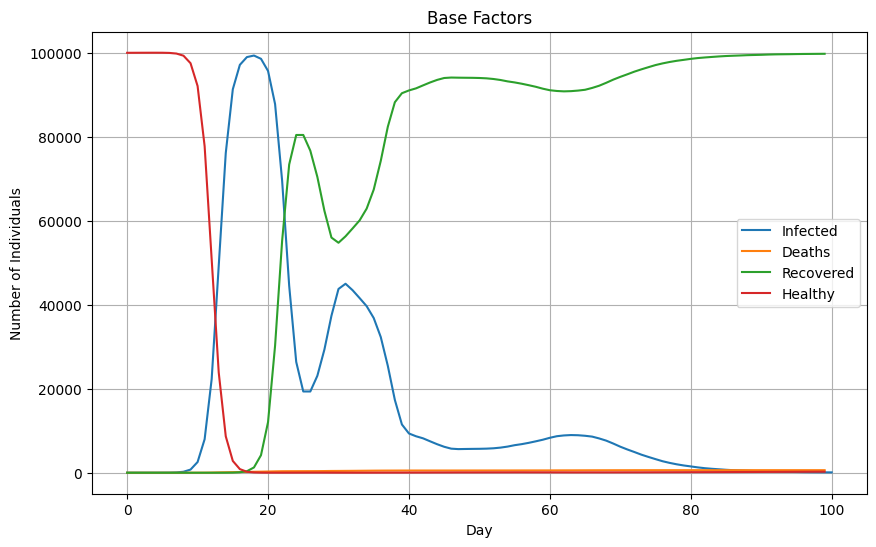

In [3]:
plt.figure(figsize=(10, 6))

# Run simulations and plot
infected_counts, deathcount, recovered, healthy, deathcounts, recoveredcounts, healthycounts = run_simulation(population_size, initial_infected, base_infection_probability, demographic_growth_rate, days, temperature_effect, mortality_rate, avg_length_sick, temperature, interactions_per_day, antibody_effectiveness)
plt.plot(infected_counts, label=f'Infected')
plt.plot(deathcounts, label=f'Deaths')
plt.plot(recoveredcounts, label=f'Recovered')
plt.plot(healthycounts, label=f'Healthy')
print('\n')

plt.xlabel('Day')
plt.ylabel('Number of Individuals')
plt.title('Base Factors')
plt.legend()
plt.grid(True)
plt.show()

Interactions per day

Start Simulation
Day 0: 1 people are infected, 0 people are dead, 0 people have recovered, 100005 people are still healthy, 0 people have been re-infected, Population: 100007
Day 10: 150 people are infected, 0 people are dead, 4 people have recovered, 99864 people are still healthy, 0 people have been re-infected, Population: 100077
Day 20: 6160 people are infected, 7 people are dead, 266 people have recovered, 91152 people are still healthy, 0 people have been re-infected, Population: 100147
Day 30: 67131 people are infected, 105 people are dead, 10084 people have recovered, 19771 people are still healthy, 693 people have been re-infected, Population: 100217
Day 40: 29864 people are infected, 230 people are dead, 71957 people have recovered, 2822 people are still healthy, 12466 people have been re-infected, Population: 100287
Day 50: 8683 people are infected, 264 people are dead, 90377 people have recovered, 1763 people are still healthy, 21148 people have been re-infected, Population

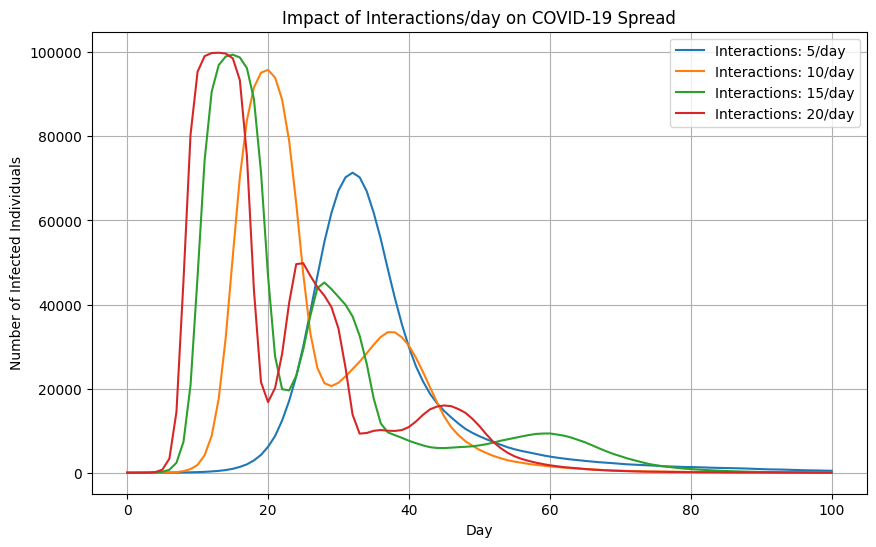

In [4]:
# Interactions to simulate
interactions = [5,10,15,20]  # Example temperatures
plt.figure(figsize=(10, 6))

# Run simulations and plot
for interaction in interactions:
    infected_counts, deathcount, recovered, healthy, deathcounts, recoveredcounts, healthycounts = run_simulation(population_size, initial_infected, base_infection_probability, demographic_growth_rate, days, temperature_effect, mortality_rate, avg_length_sick, temperature, interaction, antibody_effectiveness)
    plt.plot(infected_counts, label=f'Interactions: {interaction}/day')
    print("Deathcount: ", deathcount," Recovered: ",recovered," Healthy: ",healthy)
    print('\n')

plt.xlabel('Day')
plt.ylabel('Number of Infected Individuals')
plt.title('Impact of Interactions/day on COVID-19 Spread')
plt.legend()
plt.grid(True)
plt.show()

Start Simulation
Day 0: 1 people are infected, 0 people are dead, 0 people have recovered, 100003 people are still healthy, 0 people have been re-infected, Population: 100007
Day 10: 99901 people are infected, 173 people are dead, 29 people have recovered, 7 people are still healthy, 0 people have been re-infected, Population: 100077
Day 20: 11306 people are infected, 243 people are dead, 82849 people have recovered, 23 people are still healthy, 17169 people have been re-infected, Population: 100147
Day 30: 69955 people are infected, 364 people are dead, 39897 people have recovered, 9 people are still healthy, 95523 people have been re-infected, Population: 100217
Day 40: 59060 people are infected, 454 people are dead, 41626 people have recovered, 9 people are still healthy, 159398 people have been re-infected, Population: 100287
Day 50: 38996 people are infected, 533 people are dead, 56247 people have recovered, 9 people are still healthy, 207357 people have been re-infected, Populati

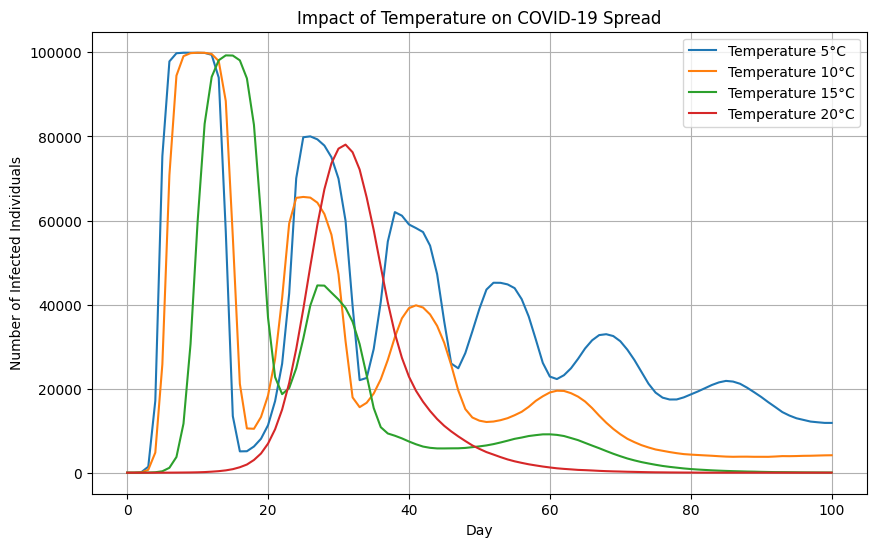

In [5]:
# Temperatures to simulate
temperatures = [5,10,15,20]  # Example temperatures
plt.figure(figsize=(10, 6))

# Run simulations and plot
for temp in temperatures:
    infected_counts, deathcount, recovered, healthy, deathcounts, recoveredcounts, healthycounts = run_simulation(population_size, initial_infected, base_infection_probability, demographic_growth_rate, days, temperature_effect, mortality_rate, avg_length_sick, temp, interactions_per_day, antibody_effectiveness)
    plt.plot(infected_counts, label=f'Temperature {temp}°C')
    print("Deathcount: ", deathcount," Recovered: ",recovered," Healthy: ",healthy)
    print('\n')

plt.xlabel('Day')
plt.ylabel('Number of Infected Individuals')
plt.title('Impact of Temperature on COVID-19 Spread')
plt.legend()
plt.grid(True)
plt.show()